# Feature Engineering

## 1. Provided Description

Dataset Description

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions

1. sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
2. test.csv - the test set. **You need to forecast the sales for these shops and products for November 2015.**
3. sample_submission.csv - a sample submission file in the correct format.
4. items.csv - supplemental information about the items/products.
5. item_categories.csv - supplemental information about the items categories.
6. shops.csv- supplemental information about the shops.

Data fields

1. ID - an Id that represents a (Shop, Item) tuple within the test set
2. shop_id - unique identifier of a shop
3. item_id - unique identifier of a product
4. item_category_id - unique identifier of item category
5. item_cnt_day - number of products sold. **You are predicting a monthly amount of this measure**
6. item_price - current price of an item
7. date - date in format dd/mm/yyyy
8. date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
9. item_name - name of item
10. shop_name - name of shop
11. item_category_name - name of item category

This challenge serves as final project for the "How to win a data science competition" Coursera course.
https://www.coursera.org/learn/competitive-data-science/home/welcome

In this competition you will work with a challenging time-series dataset consisting of daily sales data, 
kindly provided by one of the largest Russian software firms - 1C Company. https://1c.ru/eng/title.htm

We are asking you to **predict total sales for every product and store in the next month.** By solving this competition you will be able to apply and enhance your data science skills.

## 2. Loading libraries and data

In [215]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [216]:
# Copy data (competitive-data-science-final-project.zip) one level before the current directory
# and extract once. 
# Secondary extraction is done with pandas read_csv

In [217]:
# Dropping this table as it is as same as item_categories and not mentioned in the initial data description
# df_item_cats = pd.read_csv('competitive-data-science-final-project/item_cats.csv')

In [218]:
df_item_categories = pd.read_csv('../competitive-data-science-final-project/item_categories.csv')

In [219]:
df_items = pd.read_csv('../competitive-data-science-final-project/items.csv')

In [220]:
df_shops = pd.read_csv('../competitive-data-science-final-project/shops.csv')

In [221]:
df_train = pd.read_csv('../competitive-data-science-final-project/sales_train.csv.gz', compression='gzip')

In [222]:
# Dropping the current test dataset - Create a test dataset from the current 
# train dataset to cross check the effectiveness of each prediction method
#df_test = pd.read_csv('../competitive-data-science-final-project/test.csv.gz', compression='gzip')

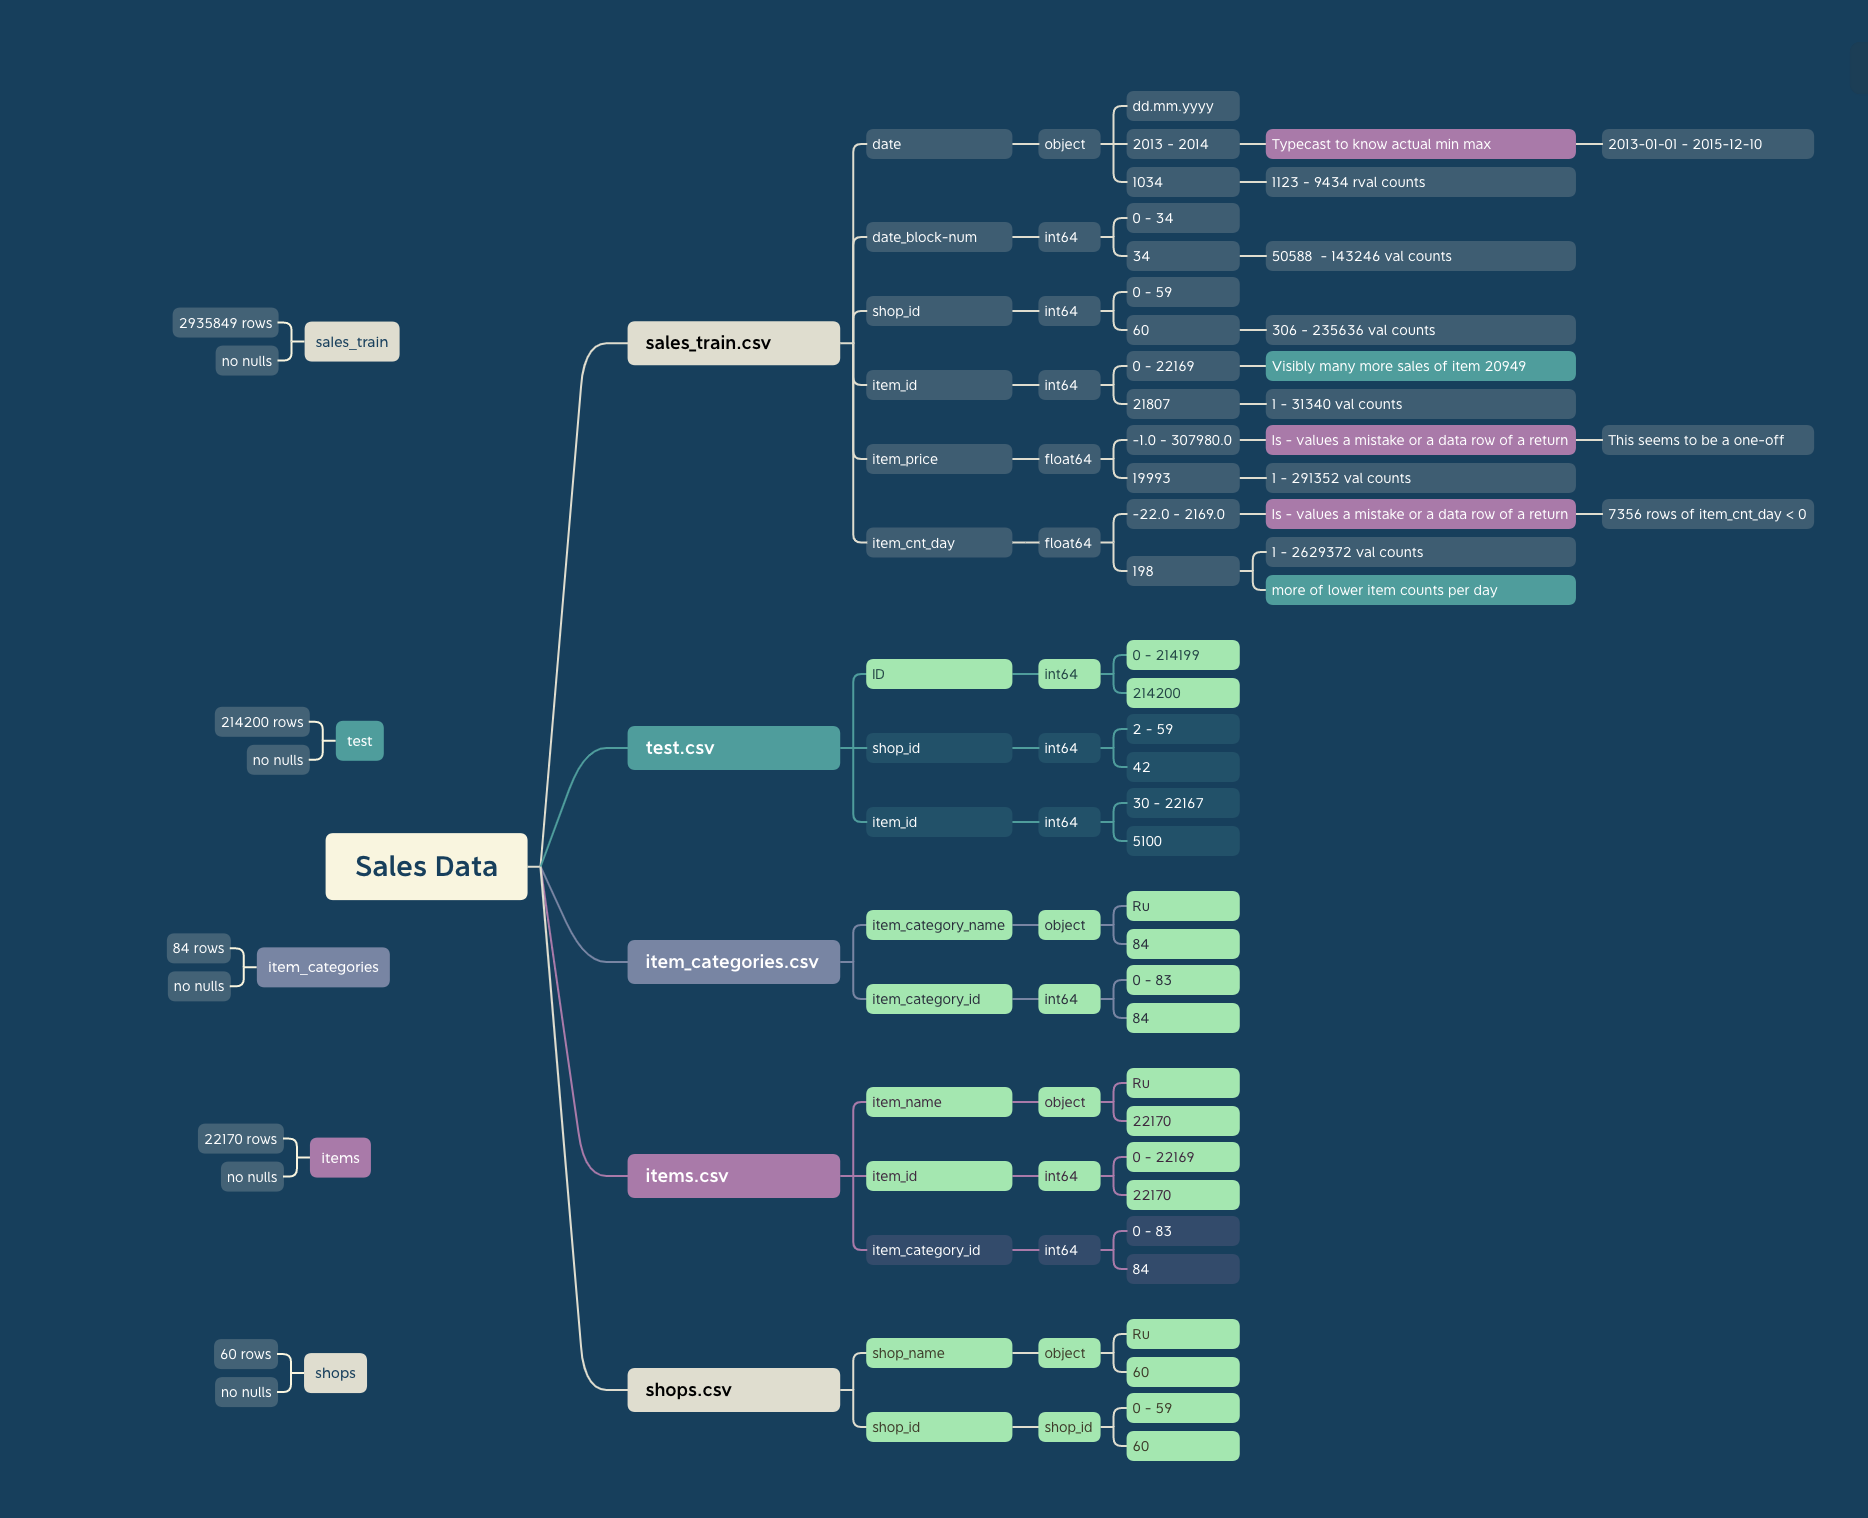

# Learnings from Exploratory Analysis

1. Type cast date column

2. Remove the 6 duplicates in the df_train 

3. Update the item_price = - 1.0 cell to the mean price of that item. Or drop.

4. Merge rows with different item price for same item to get one item_count?

5. Remove the current ID column in the df_test and if required maybe add a column with a delimiter so it can later be constructed/deconstructed/identified against shop_id and item_id.

6. Add Year_Month column. 

7. <del>Add Month column 

8. Add year column

9. Add day of week column

10. Add item category ID column

11. Create new train and test datasets

12. Exploring the new test and train datasets

# Feature Engineering Steps

## 1. Typecasting the date column, inplace.

In [223]:
df_train['date']= pd.to_datetime(df_train['date'], dayfirst=True)

In [224]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


## 2. Remove the 6 duplicates in the df_train

In [225]:
df_train.count()

date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64

In [226]:
df_train.drop_duplicates().count()

date              2935843
date_block_num    2935843
shop_id           2935843
item_id           2935843
item_price        2935843
item_cnt_day      2935843
dtype: int64

In [227]:
df_train.drop_duplicates(inplace = True)

In [228]:
df_train.count()

date              2935843
date_block_num    2935843
shop_id           2935843
item_id           2935843
item_price        2935843
item_cnt_day      2935843
dtype: int64

## 3. Update the item_price = - 1.0 cell

In [229]:
# This is not even necessary if we are dropping the column later. 
#But in case we are not; here goes;

In [230]:
df_train.head()
df_train.loc[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [231]:
# figuring out the item price for item_id = 2973

In [232]:
temp_df_item_price = df_train.loc[df_train.item_id == 2973]
temp_df_item_price.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,2013-01-15,0,25,2973,2499.0,13.0
353,2013-01-16,0,25,2973,2499.0,5.0
354,2013-01-17,0,25,2973,2499.0,3.0
355,2013-01-18,0,25,2973,2499.0,2.0
356,2013-01-19,0,25,2973,2499.0,3.0


In [233]:
print("mean: ", temp_df_item_price.item_price.mean())
print("median: ", temp_df_item_price.item_price.median())
print("mode: ", temp_df_item_price.item_price.mode())
print("range: ", temp_df_item_price.item_price.max() - 
      temp_df_item_price.item_price.min())

mean:  2041.6272774725257
median:  2499.0
mode:  0    2499.0
Name: item_price, dtype: float64
range:  2500.0


In [234]:
# Assign the modal value for item_price in place of the minus value

df_train.item_price = df_train.item_price.replace(-1.0, 2499.0)
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [235]:
df_train.loc[df_train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


## 4. Merge rows with different item price for same item to get one item_count

In [236]:
df_train[df_train.duplicated(
    subset = ["date", "shop_id", "item_id"], keep='last'
)].sort_values(by = "date")

# 70718	2013-01-25	0	31	14050	248.00	1.0 keep = 'first'
# 70686	2013-01-25	0	31	14050	349.00	1.0 keep = 'last'

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
70686,2013-01-25,0,31,14050,349.00,1.0
103461,2013-01-27,0,38,15702,549.00,1.0
6959,2013-01-29,0,25,12133,889.00,1.0
210156,2013-02-16,1,25,12133,1389.00,1.0
142696,2013-02-18,1,16,15702,149.00,1.0
284371,2013-03-02,2,16,12133,889.00,1.0
275474,2013-03-07,2,50,12133,1389.00,1.0
408103,2013-04-06,3,54,14050,198.00,1.0
1203857,2013-12-28,11,54,12133,669.00,1.0
1154619,2013-12-29,11,27,12133,999.00,1.0


In [237]:
# Dropping the price column 

In [238]:
df_train = df_train.groupby(
    ["date", "date_block_num", "shop_id", "item_id"]
)[["item_cnt_day"]].sum().reset_index()

In [239]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day
0,2013-01-01,0,2,991,1.0
1,2013-01-01,0,2,1472,1.0
2,2013-01-01,0,2,1905,1.0
3,2013-01-01,0,2,2920,2.0
4,2013-01-01,0,2,3320,1.0


In [240]:
df_train[df_train.duplicated(
    subset = ["date", "shop_id", "item_id"]
)].sort_values(by = "date")

,date,date_block_num,shop_id,item_id,item_cnt_day


## 5. Remove the current ID column in the df_test ?

In [241]:
# df_test.head()

UPDATE : This dataset was dropped

* ID in the test data set is not as the data description states

*  i.e.: (ID - an Id that represents a (Shop, Item) tuple within the test set)

* ID is not a tuple of Shop, Item combination. It is a number from the sequence starting from 0 assgned to each unique Shop_id, item_id pair, probably when data is rdered by shop_id.

## <del> 6. Add Year_Month Column</del>

In [242]:
#df_train['Year_Month'] = df_train['date'].dt.to_period('M')
#df_train.head()

## 7. Add Month Column

In [243]:
df_train["Month"] = df_train["date"].dt.month
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month
0,2013-01-01,0,2,991,1.0,1
1,2013-01-01,0,2,1472,1.0,1
2,2013-01-01,0,2,1905,1.0,1
3,2013-01-01,0,2,2920,2.0,1
4,2013-01-01,0,2,3320,1.0,1


## 8. Add Year Column

In [244]:
df_train["Year"] = df_train["date"].dt.year 
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year
0,2013-01-01,0,2,991,1.0,1,2013
1,2013-01-01,0,2,1472,1.0,1,2013
2,2013-01-01,0,2,1905,1.0,1,2013
3,2013-01-01,0,2,2920,2.0,1,2013
4,2013-01-01,0,2,3320,1.0,1,2013


## 9. Add Day of Week column

In [245]:
df_train["DayofWeek"] = df_train["date"].dt.dayofweek
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek
0,2013-01-01,0,2,991,1.0,1,2013,1
1,2013-01-01,0,2,1472,1.0,1,2013,1
2,2013-01-01,0,2,1905,1.0,1,2013,1
3,2013-01-01,0,2,2920,2.0,1,2013,1
4,2013-01-01,0,2,3320,1.0,1,2013,1


## 10. Add item category ID Column

In [246]:
df_train = df_train.join(df_items, 
              on="item_id", 
              how='left', 
              rsuffix = "_ITEMS_")

In [247]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_name,item_id_ITEMS_,item_category_id
0,2013-01-01,0,2,991,1.0,1,2013,1,"3D Action Puzzle ""Динозавры"" Тиранозавр",991,67
1,2013-01-01,0,2,1472,1.0,1,2013,1,"Assassin's Creed 3 [Xbox 360, русская версия]",1472,23
2,2013-01-01,0,2,1905,1.0,1,2013,1,"Bestseller. Grand Theft Auto: San Andreas [PC,...",1905,30
3,2013-01-01,0,2,2920,2.0,1,2013,1,Disney. LEGO Пираты Карибского моря (Essential...,2920,21
4,2013-01-01,0,2,3320,1.0,1,2013,1,"FIFA 13 (с поддержкой PS Move) [PS3, русская в...",3320,19


In [248]:
# Dropping the unwanted columns

df_train = df_train.drop(["item_name", "item_id_ITEMS_"], axis=1)
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id
0,2013-01-01,0,2,991,1.0,1,2013,1,67
1,2013-01-01,0,2,1472,1.0,1,2013,1,23
2,2013-01-01,0,2,1905,1.0,1,2013,1,30
3,2013-01-01,0,2,2920,2.0,1,2013,1,21
4,2013-01-01,0,2,3320,1.0,1,2013,1,19


In [249]:
df_train.tail()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id
2935816,2015-10-31,33,59,20730,1.0,10,2015,5,72
2935817,2015-10-31,33,59,20866,1.0,10,2015,5,72
2935818,2015-10-31,33,59,20949,1.0,10,2015,5,71
2935819,2015-10-31,33,59,21369,1.0,10,2015,5,40
2935820,2015-10-31,33,59,21449,1.0,10,2015,5,40


## 11. Adding Holidays Column

In [250]:
!pip install holidays

Defaulting to user installation because normal site-packages is not writeable


In [251]:
import holidays

In [259]:
from datetime import date

In [290]:
Ru_hols = holidays.country_holidays('RU')

#print(df_train.date[2000000].to_pydatetime())
#print(Ru_hols.get(df_train.date[2000000].to_pydatetime()))

In [298]:
arr = []
for i in df_train.date:
    arr.append(i.to_pydatetime() in Ru_hols)
print("Done")

Done


In [300]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id
0,2013-01-01,0,2,991,1.0,1,2013,1,67
1,2013-01-01,0,2,1472,1.0,1,2013,1,23
2,2013-01-01,0,2,1905,1.0,1,2013,1,30
3,2013-01-01,0,2,2920,2.0,1,2013,1,21
4,2013-01-01,0,2,3320,1.0,1,2013,1,19


In [301]:
df_train["Holiday"] = arr

In [302]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id,Holiday
0,2013-01-01,0,2,991,1.0,1,2013,1,67,True
1,2013-01-01,0,2,1472,1.0,1,2013,1,23,True
2,2013-01-01,0,2,1905,1.0,1,2013,1,30,True
3,2013-01-01,0,2,2920,2.0,1,2013,1,21,True
4,2013-01-01,0,2,3320,1.0,1,2013,1,19,True


## 12. Creating new datasets

In [303]:
# Drop the current testing data set. 
# Consider data from the training dataset up to 2015-09-30 as the training data 
# and 2015-10-01 to 2015-10-31 ( without the item_cnt_day/target ) as the testing data. 
# This is so that we can determine how well we predicted each method/model compared to the real data.

In [304]:
df_train.loc[df_train.date < '2015-10-01'].tail()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id,Holiday
2882303,2015-09-30,32,59,15069,1.0,9,2015,2,28,False
2882304,2015-09-30,32,59,15255,1.0,9,2015,2,63,False
2882305,2015-09-30,32,59,15256,2.0,9,2015,2,63,False
2882306,2015-09-30,32,59,16184,1.0,9,2015,2,65,False
2882307,2015-09-30,32,59,22088,1.0,9,2015,2,83,False


In [305]:
new_df_train = df_train.loc[df_train.date < '2015-10-01']

In [306]:
new_df_train.head()

,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id,Holiday
0,2013-01-01,0,2,991,1.0,1,2013,1,67,True
1,2013-01-01,0,2,1472,1.0,1,2013,1,23,True
2,2013-01-01,0,2,1905,1.0,1,2013,1,30,True
3,2013-01-01,0,2,2920,2.0,1,2013,1,21,True
4,2013-01-01,0,2,3320,1.0,1,2013,1,19,True


In [307]:
new_df_train.date.agg(["min", "max"])

min   2013-01-01
max   2015-09-30
Name: date, dtype: datetime64[ns]

In [308]:
temp_df_test = df_train.loc[df_train.date > '2015-09-30']

In [309]:
temp_df_test.date.agg(["min", "max"])

min   2015-10-01
max   2015-10-31
Name: date, dtype: datetime64[ns]

In [310]:
temp_df_test.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day', 'Month',
       'Year', 'DayofWeek', 'item_category_id', 'Holiday'],
      dtype='object')

In [311]:
new_df_test = temp_df_test.drop("item_cnt_day", axis=1).reset_index().drop("index", axis=1)
new_df_test

,date,date_block_num,shop_id,item_id,Month,Year,DayofWeek,item_category_id,Holiday
0,2015-10-01,33,2,2791,10,2015,3,20,False
1,2015-10-01,33,2,3351,10,2015,3,20,False
2,2015-10-01,33,2,3353,10,2015,3,24,False
3,2015-10-01,33,2,3708,10,2015,3,19,False
4,2015-10-01,33,2,4388,10,2015,3,20,False
...,...,...,...,...,...,...,...,...,...
53508,2015-10-31,33,59,20730,10,2015,5,72,False
53509,2015-10-31,33,59,20866,10,2015,5,72,False
53510,2015-10-31,33,59,20949,10,2015,5,71,False
53511,2015-10-31,33,59,21369,10,2015,5,40,False


## 13. Exploring the new train and test datasets

In [312]:
def explore(df):
    summary_df = pd.DataFrame()
    
    for i in df.columns:
        line_df = pd.DataFrame([i, 
                                df[i].dtype, 
                                df[i].count(), 
                                df[i].min(), 
                                df[i].max(), 
                                df[i].nunique(), 
                                df[i].isna().sum()]
                              )
        summary_df = pd.concat([ summary_df,line_df], axis=1)
        #summary_df = summary_df.concat()
    summary_df.index = [ "Column_name","dtype", "Total", "Min", "Max", "nUnique", "Nullcount"]
    #Making the first row the column header
    summary_df.columns = summary_df.iloc[0]
    summary_df = summary_df[1:]
    
    return(summary_df)

In [313]:
explore(new_df_train)

Column_name,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id,Holiday
dtype,datetime64[ns],int64,int64,int64,float64,int32,int32,int32,int64,bool
Total,2882308,2882308,2882308,2882308,2882308,2882308,2882308,2882308,2882308,2882308
Min,2013-01-01 00:00:00,0,0,0,-22.0,1,2013,0,0,False
Max,2015-09-30 00:00:00,32,59,22169,1000.0,12,2015,6,83,True
nUnique,1003,33,59,21332,198,12,3,7,84,2
Nullcount,0,0,0,0,0,0,0,0,0,0


In [314]:
explore(new_df_test)

Column_name,date,date_block_num,shop_id,item_id,Month,Year,DayofWeek,item_category_id,Holiday
dtype,datetime64[ns],int64,int64,int64,int32,int32,int32,int64,bool
Total,53513,53513,53513,53513,53513,53513,53513,53513,53513
Min,2015-10-01 00:00:00,33,2,30,10,2015,0,2,False
Max,2015-10-31 00:00:00,33,59,22167,10,2015,6,83,False
nUnique,31,1,44,5413,1,1,7,63,1
Nullcount,0,0,0,0,0,0,0,0,0


In [315]:
explore(temp_df_test)

Column_name,date,date_block_num,shop_id,item_id,item_cnt_day,Month,Year,DayofWeek,item_category_id,Holiday
dtype,datetime64[ns],int64,int64,int64,float64,int32,int32,int32,int64,bool
Total,53513,53513,53513,53513,53513,53513,53513,53513,53513,53513
Min,2015-10-01 00:00:00,33,2,30,-1.0,10,2015,0,2,False
Max,2015-10-31 00:00:00,33,59,22167,2169.0,10,2015,6,83,False
nUnique,31,1,44,5413,55,1,1,7,63,1
Nullcount,0,0,0,0,0,0,0,0,0,0


In [316]:
# Exploring the number of unique shop_id by date_block_num

In [317]:
unique_shops_per_month = df_train.groupby(["date_block_num"])[["shop_id"]].nunique().reset_index()

In [318]:
unique_shops_per_month.head()

,date_block_num,shop_id
0,0,45
1,1,46
2,2,46
3,3,46
4,4,45


Text(0, 0.5, "Number of unique shop_id's")

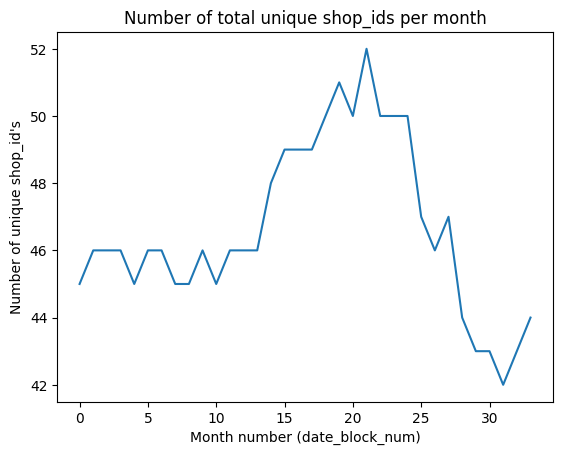

In [319]:
ax = sns.lineplot(data = unique_shops_per_month, x = "date_block_num", y = "shop_id")

ax.set(title = "Number of total unique shop_ids per month")
ax.set_xlabel( "Month number (date_block_num)")
ax.set_ylabel( "Number of unique shop_id's")


In [320]:
# new data
new_unique_shops_per_month = new_df_train.groupby(["date_block_num"])[["shop_id"]].nunique().reset_index()

Text(0, 0.5, "Number of unique shop_id's")

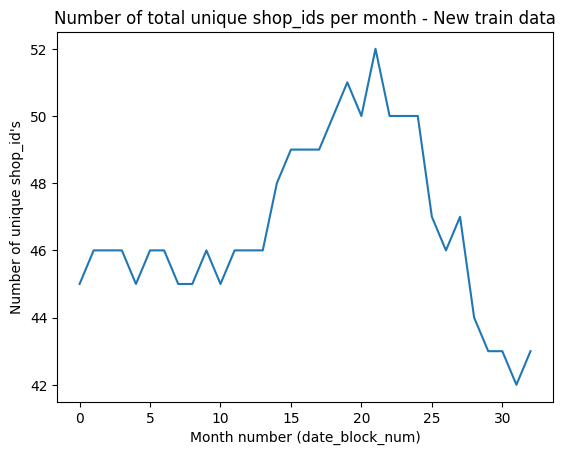

In [321]:
ax = sns.lineplot(data = new_unique_shops_per_month, x = "date_block_num", y = "shop_id")

ax.set(title = "Number of total unique shop_ids per month - New train data")
ax.set_xlabel( "Month number (date_block_num)")
ax.set_ylabel( "Number of unique shop_id's")

In [322]:
new_df_test.shop_id.unique()

array([ 2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22,
       24, 25, 26, 28, 31, 34, 35, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48,
       49, 50, 52, 53, 55, 56, 57, 58, 59, 36])

In [323]:
new_df_train.shop_id.unique()

array([ 2,  7,  8, 13, 14, 15, 18, 19, 27, 28, 37, 38, 41, 42, 46, 51, 54,
        3,  4,  6, 10, 16, 21, 22, 23, 24, 25, 26, 29, 30, 31, 32, 35, 44,
       45, 47, 50, 52, 53, 56, 59,  0,  1, 12, 43,  5, 57, 58, 55, 17,  9,
       49, 39, 40, 48, 34, 33, 20, 11])

In [324]:
# Missing shops percentage 
(
    (new_df_train.shop_id.nunique() - new_df_test.shop_id.nunique()) / new_df_train.shop_id.nunique()
) * 100

25.423728813559322

In [325]:
# Missing categories percentage 
(
    (new_df_train.item_category_id.nunique() - new_df_test.item_category_id.nunique()) / new_df_train.item_category_id.nunique()
) * 100

25.0

In [326]:
# Missing items percentage 
(
    (new_df_train.item_id.nunique() - new_df_test.item_id.nunique()) / new_df_train.item_id.nunique()
) * 100

74.62497656103506

## 14. Exploring new datasets with Pandas Profiling

In [327]:
!python3 --version

Python 3.7.9


In [328]:
# Installing pandas profiling with new package name
!pip install ydata-profiling

Defaulting to user installation because normal site-packages is not writeable


In [329]:
# Profiling as timeseries data

from ydata_profiling import ProfileReport

#df = pd.read_csv("ts_data.csv")
profile = ProfileReport(new_df_train, minimal=True)
#profile.to_file("output.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [330]:
test_profile = ProfileReport(new_df_test, minimal=True)
test_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Removed Year_Month Column 